# Objective

Find the best `cleanup_gaussian_sigma` parameter based on visual result. Greg: "Set “cleanup_gaussian_sigma” to the lowest value that avoids creating edge artifacts that bleed through the normxcorr step. It is a parameter that hasn't had much real tweaking yet."

# Dataset

Image `20200901-193823-6`

# Preprocessing

- CCI1 package: https://drive.google.com/file/d/1m6CSpnfHtRLSL62ZmZthWU63WGqdBt9q/view?usp=sharing

- normxcorr2 (from https://github.com/czbiohub/cell-counting-imager/blob/828b8af950beb32ff76548f11764c8915bb9b6d6/cell_counting_imager/normxcorr2.py)

### Preprocessing Process:

Get pred_count
- Feed in full-size FG and BG images
- Apply Greg’s CCI 1 preprocessing code to the FG image
- Apply normalized cross-correlation to the FG image
- Crop the preprocessed FG image
- blob_dog counting on the preprocessed, cropped FG image

Get gt_count
- Shift/scale the GT annotations
- Use the mask to throw out GT annotations in invalid areas
- Count the GT annotations in valid areas

# Results

Setting `cleanup_gaussian_sigma` = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0] seems to yield the exact same result (i.e. image) after the normxcorr step. There do not seem to be edge artifacts that bleed through the normxcorr step at any of thse `cleanup_gaussian_sigma` values.

Setting `cleanup_gaussian_sigma` = np.arange(0, 1.1, 0.1) gives results (i.e. images) after the normxcorr step that are slightly different from each other, but it is not obvious to my eyes what the cutoff value should be, where there seem to be more or less in terms of edge artifacts that bleed through the normxcorr step at any of thse cleanup_gaussian_sigma values.

So, in my cci1 blob detection tests, I will vary `cleanup_gaussian_sigma` among the values of np.arange(0, 1.1, 0.1) and see which value of `cleanup_gaussian_sigma` gives me the best predicted blob counts. When I do this, I will start with `input_gaussian_sigma` = None.

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from normxcorr2 import normxcorr2
from skimage.feature import blob_dog
from skimage.io import imread
from skimage import exposure, transform
from scipy.stats import linregress
from matplotlib.lines import Line2D
import warnings, math
warnings.filterwarnings('ignore')

In [8]:
import cci_image_processing
from skimage.io import imread

In [9]:
# using default kernel params
kernelSize = 150
ds = 2 # down-sampling integer factor along each axis
discRadius = 3

# set up kernel
kernel = np.zeros((kernelSize, kernelSize), 'uint16')
kernelCtr = kernelSize/2
for rr in range(0, kernelSize + 1):
    for cc in range(0, kernelSize + 1):
        if  math.sqrt((rr - kernelCtr)**2 + (cc - kernelCtr)**2) < discRadius:
            kernel[rr, cc] = 65535
kernel = transform.downscale_local_mean(kernel, (ds,ds))

def cross_correlate(im):
    im_normxcorr2 = normxcorr2(kernel, im)
    lr_edge = (im_normxcorr2.shape[0] - im.shape[0])/2
    ud_edge = (im_normxcorr2.shape[1] - im.shape[1])/2
    return im_normxcorr2[int(ud_edge):int(ud_edge*-1), int(ud_edge):int(ud_edge*-1)]

In [10]:
bubble_image_names = [
    '20200901-193536-2',
    '20200916-192532-4',
    '20201002-131101-4'
]
bubble_image_names_test = [
    '20201217-142717-5',
    '20201217-142717-2',
    '20201217-142717-0',
    '20201216-163816-1',
    '20201216-141203-7',
    '20201216-135719-5',
    '20201216-135719-2'
]

# Test Run

In [21]:
def test_cgs(cgs_list):
    for cgs in cgs_list:

    #     print('cgs = %s' % cgs)

        # Greg's demo settings
        pp = cci_image_processing.Cci1ImagePreprocessing(
            input_rescale_factor =   0.5,
            input_gaussian_sigma =   1.0, # used to be 2.0
            align_bg_pixel_thresh =  0.25,
            align_bg_row_thresh =    0.35,
            align_mask_margin =      0.01,
            align_cutout_height =    0.75,
            align_oversub_factor =   1.05,
            cleanup_wall_margin =    0.05,
            cleanup_bg_brt_thresh =  0.25,
            cleanup_bg_grow_factor = 1.0e-2,
            cleanup_fg_brt_thresh =  0.05,
            cleanup_fg_grow_factor = 1.0e-2,
            cleanup_fg_grow_cycles = 4,
            cleanup_fg_size_thresh = 3.0e-4,
            cleanup_gaussian_sigma = cgs,
        )

        BG_IMAGE_PATH = 'all_bg/background-%s.tif' % name
        ycrop = int((2048-948)/2)
        xcrop = int((2448-1948)/2)
        bg_img = imread(BG_IMAGE_PATH)
        info = pp.set_bg_image(bg_img)
        FG_IMAGE_PATH = 'raw_images/image-%s.tif' % name
        fg_cleaned, valid_area, info = pp.process_fg_image_from_path(FG_IMAGE_PATH)
        fg_cleaned_xcorr = cross_correlate(fg_cleaned)

    #     plt.figure(figsize=(8.,8.))
    #     plt.imshow(fg_cleaned)
    #     plt.title("Input Image Cleaned Using Greg's Code, CGS = %f" % cgs)
    #     plt.show()

        plt.figure(figsize=(8.,8.))
        plt.imshow(fg_cleaned_xcorr)
        plt.title("Input Image Cleaned Using Greg's Code, then Cross Correlated\ncleanup_gaussian_sigma = %f" % cgs)
        plt.show()

In [22]:
name = '20200901-193823-6'

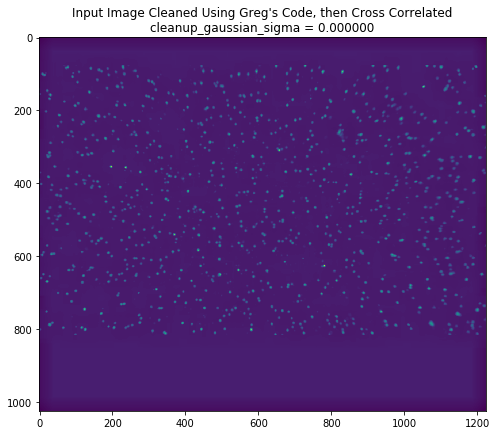

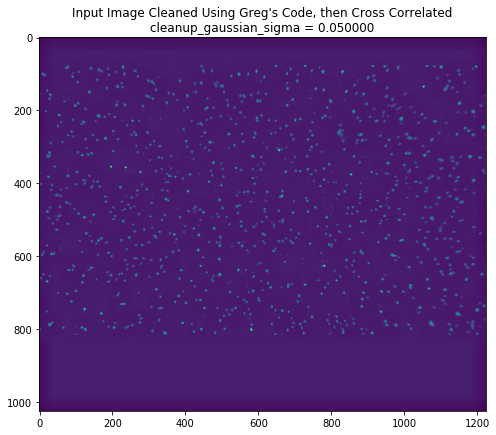

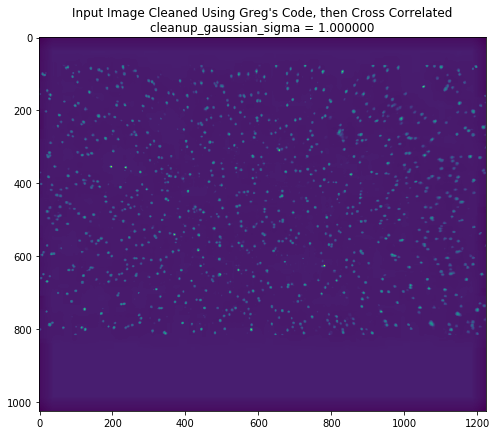

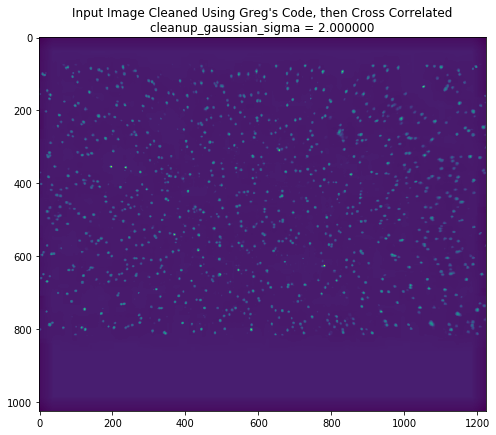

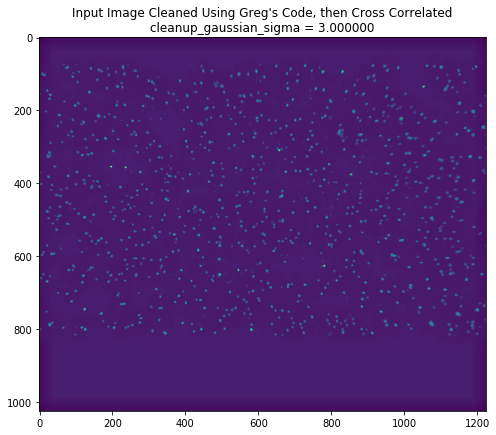

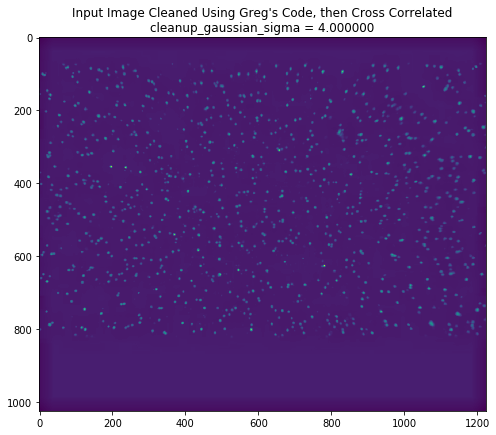

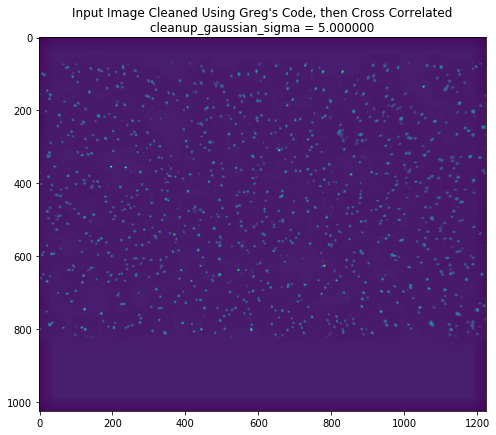

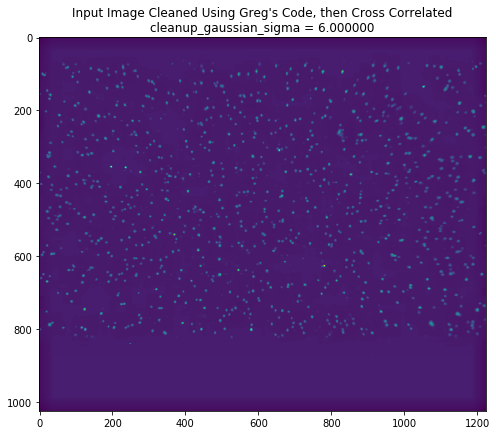

In [23]:
cgs_list = [0.0, 0.05, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
test_cgs(cgs_list)

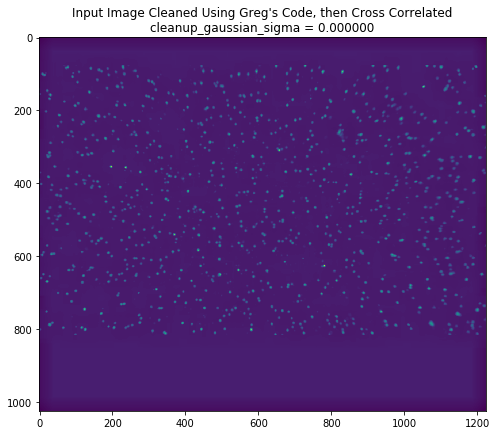

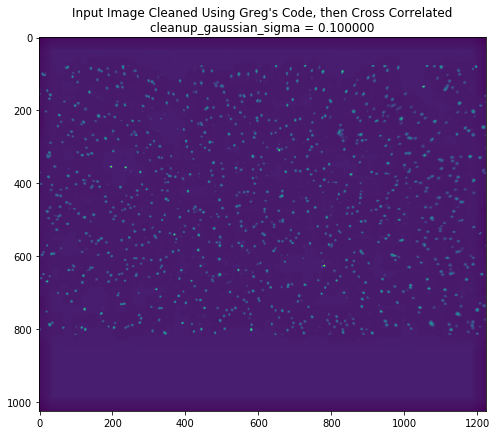

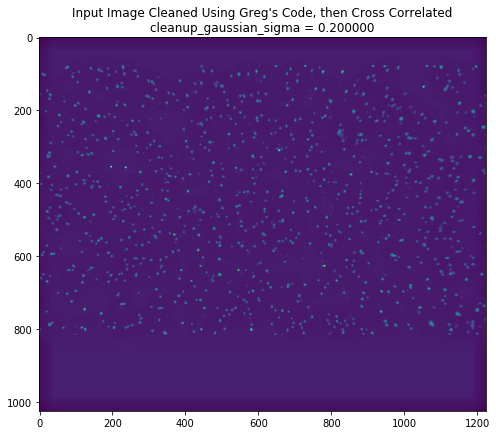

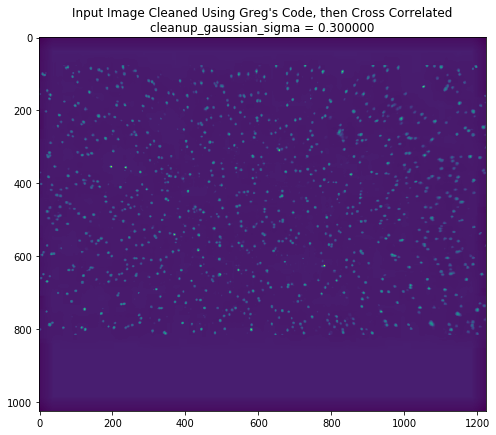

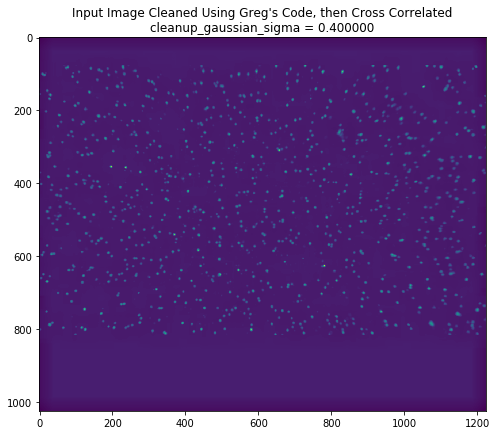

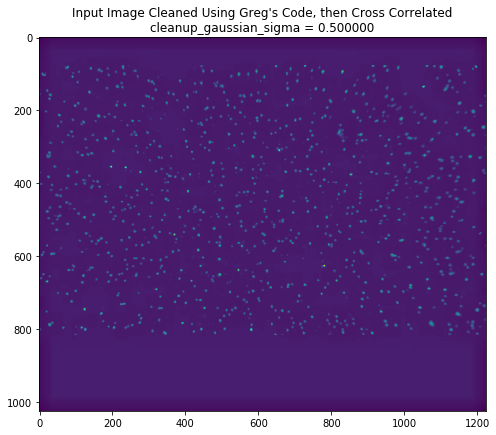

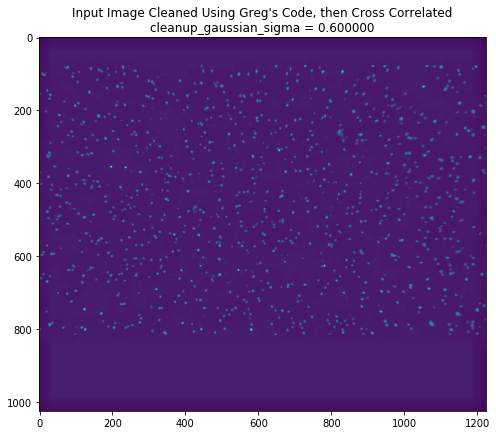

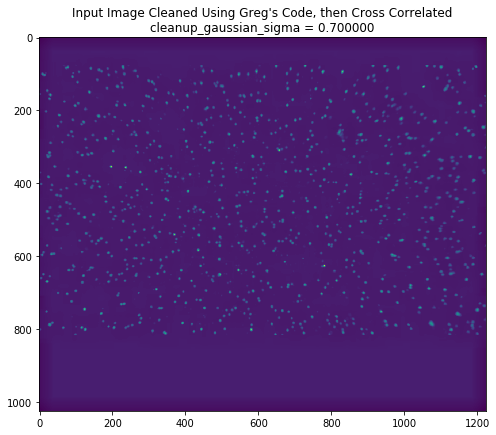

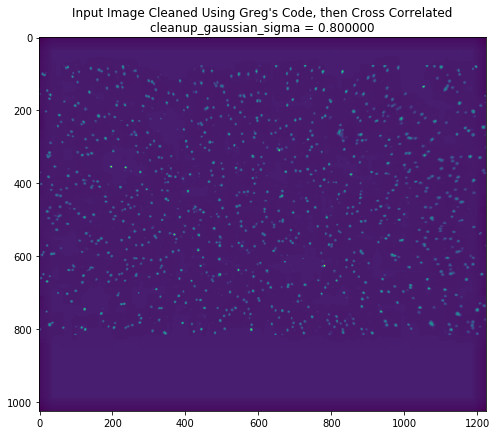

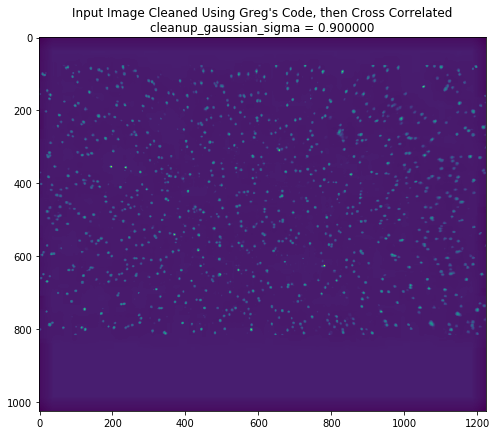

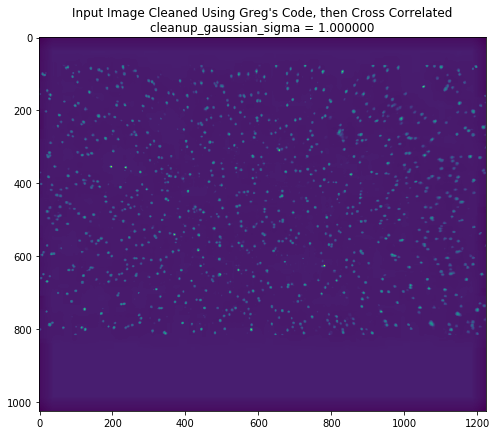

In [24]:
cgs_list = np.arange(0, 1.1, 0.1)
test_cgs(cgs_list)